In [1]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
import awkward as ak
import MyHelpers as mh
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed


#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.24/00


In [2]:
#Getting files
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_14TeV_PU200_NTUPLE_jobs123merge_version4.root'
#load the file content
tree = uproot.open(filename+":myana/mytree")
tree.show()

filename=PATH+'DYMuMu_PU200_NTUPLE_1_version3.root'
bg_tree = uproot.open(filename+":myana/mytree")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [3]:
#Create signal tree
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'], '(genproton_ispu == 0) & (abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')  
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 
#(abs(genproton_xi)> 0.0032) & 
#Create background tree
#Compressing the muon data
bg_muons =[]
for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
    bg_muons.append(batch[(abs(batch.pfcand_pid)==13) & (batch.pfcand_pt>25)] )
bg_muons=ak.concatenate(bg_muons)

bg_protons = bg_tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'],'(abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')
bg_event_info = bg_tree.arrays(['genvtx_t0']) 
bg_vertices = bg_tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2'])

In [4]:
sqrt_s = 14000
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns 

#define data array for signal
sig_data = {}
mh.InitData(sig_data)
#loop over all events for the signal
N = len(muons)
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)            
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue 
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    xi_dimu_plus = ((mu1.Pt()*np.exp(mu1.Rapidity())+mu2.Pt()*np.exp(mu2.Rapidity())) / sqrt_s) 
    xi_dimu_minus =((mu1.Pt()*np.exp(-mu1.Rapidity())+mu2.Pt()*np.exp(-mu2.Rapidity())) / sqrt_s)
    #additional cut
    if((xi_dimu_plus<0.0032) == True & (xi_dimu_minus<0.0032) == True): continue   
    # find two signal protons:
    pr=protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = mh.SelProtons(pr,mu1,mu2, xi_dimu_plus, xi_dimu_minus)
    if pr1_idx<0 or pr2_idx<0: continue
    vx = vertices[i]
    ev = event_info[i]
    #Filling muon and proton events
    mh.Fill_mu(sig_data, mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(sig_data,pr,pr1_idx,pr2_idx,vx,ev)
    mh.Sig_time(sig_data, ev, pr, pr1_idx, pr2_idx)
    #Add smeared proton times
    mh.Fill_smeared_pr_t(sig_data)
sig = pd.DataFrame(data=sig_data)

#define data array for Background
bg_data = {}
mh.InitData(bg_data)
#loop over all events for the background
n = len(bg_muons)
for i in tqdm(range(n)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)    
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue 
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    xi_dimu_plus = ((mu1.Pt()*np.exp(mu1.Rapidity())+mu2.Pt()*np.exp(mu2.Rapidity())) / sqrt_s) 
    xi_dimu_minus =((mu1.Pt()*np.exp(-mu1.Rapidity())+mu2.Pt()*np.exp(-mu2.Rapidity())) / sqrt_s)
    #additional cut
    if((xi_dimu_plus<0.0032) == True & (xi_dimu_minus<0.0032) == True): continue 
    # find two signal protons:
    pr=bg_protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = mh.SelProtons(pr,mu1,mu2, xi_dimu_plus, xi_dimu_minus)
    #if pr1_idx<0 or pr2_idx<0: continue
    vx = bg_vertices[i]
    ev = bg_event_info[i]
    #Filling muon and proton events
    mh.Fill_mu(bg_data,mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(bg_data,pr,pr1_idx,pr2_idx,vx,ev) 
    mh.Bg_time(bg_data, pr, pr1_idx, pr2_idx)
    #Add smeared proton times
    mh.Fill_smeared_pr_t(bg_data)
bg = pd.DataFrame(data=bg_data)


100%|██████████| 15296/15296 [01:11<00:00, 213.32it/s]


122


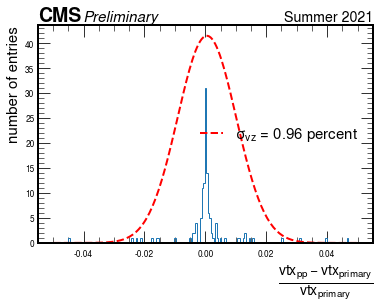

In [5]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
#p1 has pos index -> pz > 0
#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
#    data['pr1_20_t'] 
#    data['pr2_20_t']
#    data['pr1_60_t'] 
#    data['pr2_60_t'] 
p1_t = sig['pr1_t']
p2_t = sig['pr2_t'] 

pp_vz = - (p1_t - p2_t)*c/2 

vz_4D = sig['pr_vtx_z']

data = (pp_vz - vz_4D)/vz_4D
#print(data)
data = data[~np.isnan(data) & (abs(data) < 0.05) ]
print((len(data)))
bins = np.linspace(-0.05,0.05,200)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_vz, sigma_vz) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_vz, sigma_vz)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{vz}$ = %2.2f percent'%(sigma_vz*100))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize=15)
ax.set(xlabel=r'$\frac{vtx_{pp} - vtx_{primary}}{vtx_{primary}}$', ylabel='number of entries')
ax.legend(fontsize=15)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(15)

plt.savefig('Week7/fit_vz_ratio.png',bbox_inches='tight')

acceptance rate from background cut:
0.006381435823060188
acceptance rate from signal cut:
0.6745562130177515


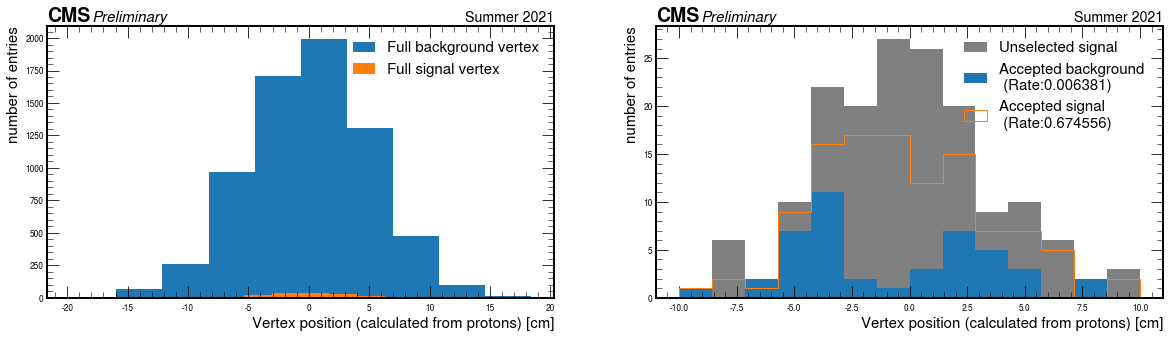

In [7]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
#proton_t= sig['evt_t0'] + (np.average(sig['pr1_vz'].values + sig['pr2_vz'].values) + zpps)/c
#b_p1_t =  bg['evt_t0'].values + ( bg['pr1_vz'].values + zpps)/c # !!! evt_t0 is in ns - but it will cncel out in the next step anyway...
#b_p2_t =  bg['evt_t0'].values - ( bg['pr2_vz'].values - zpps)/c
#pr_t = np.random.normal(0,0.19) + (zpps - sgn(pr_z)*pr_vz) / c
b_p1_t = bg['pr1_t']
b_p2_t = bg['pr2_t'] 

b_pp_vz = - (b_p1_t - b_p2_t)*c/2 

b_mu = (bg['mu1_vz'] + bg['mu2_vz'])/2
b_vz_4D = bg['pr_vtx_z'].values

data_bz = abs(b_pp_vz - b_vz_4D)

b_z = []
for i in range(0,len(data_bz)):
    if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):
            b_z = np.append(b_z,b_pp_vz[i])
acc_bg = len(b_z)/len(data_bz)
print('acceptance rate from background cut:')
print(acc_bg)

#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
#proton_t= sig['evt_t0'] + (np.average(sig['pr1_vz'].values + sig['pr2_vz'].values) + zpps)/c
p1_t = sig['pr1_t']
p2_t = sig['pr2_t'] 

s_pp_vz = - (p1_t - p2_t)*c/2 

#mu_vz = (sig['pr1_vz'].values + zpps + sig['pr2_vz'].values - zpps)/2
s_vz_4D = sig['pr_vtx_z']

data_sz = abs(s_pp_vz - s_vz_4D)
s_z = []
for i in range(0,len(data_sz)):
    if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
            s_z = np.append(s_z, s_pp_vz[i])
acc_sig =len(s_z)/len(data_sz)
print('acceptance rate from signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)

ax[0].hist(b_pp_vz, label = 'Full background vertex')
ax[0].hist(s_pp_vz, label='Full signal vertex')
ax[0].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')
#ax[0].set_xlim(-20,20)
bins = np.linspace(-10,10,15)

ax[1].hist(s_pp_vz,bins, color = "grey",label='Unselected signal')
ax[1].hist(b_z, bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_z,bins, histtype = 'step', label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 15)
    ax[i].legend(fontsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('Week7/surviving_protons_vz', bbox_inches='tight')

107


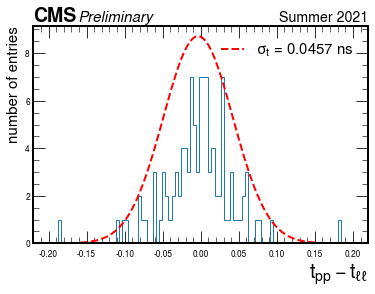

In [17]:
#Vertex position in time: (tp1 + tp2)*c = 2 zpps + t(mu)*c
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
mu1_t = masked_analysis['mu1_t'].values 
mu2_t = masked_analysis['mu2_t'].values 

p1_t =  masked_analysis['pr1_t'].values 
p2_t =  masked_analysis['pr2_t'].values 

#    data['pr1_20_t'] 
#    data['pr2_20_t']
#    data['pr1_60_t'] 
#    data['pr2_60_t'] 
#p1_t = sig['pr1_t']
#p2_t = sig['pr2_t'] 


evt_t = masked_analysis['evt_t0'].values
pr_t = masked_analysis['pr_vtx_t'].values
tpp =  (( p1_t + p2_t) - 2*zpps/c)/2

tmu =  ( mu1_t + mu2_t)/2

data = (tpp-tmu)
#print((data))
data = data[~np.isnan(data) & ~np.isneginf(data)  ]
print(len(data))
bins = np.linspace(-0.2,0.2,100)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area)
(mu_t, sigma_t) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_t, sigma_t)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{t}$ = %4.4f ns'%(sigma_t))
#print(y)
#print(x)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize = 15)
ax.set(xlabel=r'$t_{pp} - t_{\ell\ell}$', ylabel='number of entries')
ax.legend(fontsize=15)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(15)
plt.savefig('Week7/fit_vertex_t.png',bbox_inches='tight')

In [32]:
#timing
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
mask_measured_time = (bg['mu1_t'] >-80) & (bg['mu2_t']>-80)
b_masked_analysis=bg[mask_measured_time]

mu1_t = b_masked_analysis['mu1_t'].values 
mu2_t = b_masked_analysis['mu2_t'].values 

b_tmu = (mu1_t+mu2_t)/2 
#print(len(b_masked_analysis['pr1_vz'].values))
#    data['pr1_20_t'] 
#    data['pr2_20_t']
#    data['pr1_60_t'] 
#    data['pr2_60_t'] 
#p1_t = sig['pr1_t']
#p2_t = sig['pr2_t'] 

b_p1_t = b_masked_analysis['pr1_t']
b_p2_t = b_masked_analysis['pr2_t']
b_tpp = (( b_p1_t + b_p2_t) - 2*zpps/c)/2

#print(b_tpp)
data_bt =[]
data_bt = abs(b_tpp - b_tmu)
#print((b_tpp - b_tmu))
b_t = []
for i in range(0,len(data_bt)):
    if (data_bt[i] < abs(2*sigma_t)):
    b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
tmu1 = masked_analysis['mu1_t'].values 
tmu2 = masked_analysis['mu2_t'].values 

#print(len(tmu1))
p1_t =  masked_analysis['pr1_t'].values
p2_t =  masked_analysis['pr2_t'].values

s_tpp =(( p1_t + p2_t) - 2*zpps/c)/2
s_tmu = ( tmu1 + tmu2)/2
print(len(s_tpp))
print(len(s_tmu))
data_st = abs(s_tpp - s_tmu)
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
            s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

0.02272672310868984


KeyError: 1

NameError: name 's_tpp' is not defined

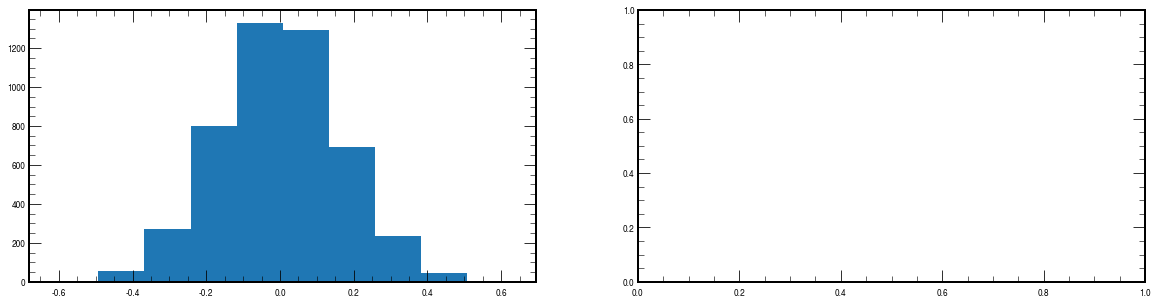

In [12]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-8,8,16)
ax[0].hist(b_tpp, label = 'Background protons')
ax[0].hist(s_tpp,histtype='step', label='Signal protons')
ax[0].set(xlabel=r'Vertex time (calculated from protons) [ns]')
#ax[0].set_xlim(-20,20)
bins=np.linspace(-0.8,0.8,20)
ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal')
ax[1].hist(b_t, bins,label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_t,bins, histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 15)
    ax[i].legend(fontsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('Week7/surviving_protons_t', bbox_inches='tight')

In [13]:
#combined timing and spatial vertex cuts:
b_z = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_bz[i] < abs(2*sigma_vz*b_vz_4D[i]):
                b_z = np.append(b_z,b_pp_vz[i])
                b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

s_z = []
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
        if data_sz[i] < abs(2*sigma_vz*s_vz_4D[i]):
                s_z = np.append(s_z, s_pp_vz[i])
                s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

KeyError: 1

In [ ]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
#bins = np.linspace(-4,4,10)
ax[0].hist(s_pp_vz, color= 'grey', label = 'Unselected Signal')
ax[0].hist(b_z, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[0].hist(s_z, histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[0].set(xlabel=r'Vertex position (calculated from protons) [cm]', ylabel='number of entries')
bins = np.linspace(-0.6,0.6,15)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')

ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal')
ax[1].hist(b_t,bins, label='Accepted background \n (Rate:%6.6f)'%acc_bg)
ax[1].hist(s_t,bins,histtype='step',label='Accepted signal \n (Rate:%6.6f)'%acc_sig)
ax[1].set(xlabel=r'Vertex time (calculated from protons) [ns]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 15)
    ax[i].legend(fontsize=15)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('Week7/surviving_protons_tvz', bbox_inches='tight')